# Assignment 4 Task 2

In [ ]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [ ]:
# Enable autoreloading if import packages are changed
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image

plt.rcParams['figure.figsize'] = [20, 12]

'''
ADJUSTABLE PARAMETERS:
downsample_factor: increase to make the loaded images smaller
max_disparity: decrease to consider fewer disparities
'''
downsample_factor = 4 # For the submission, use value of 4
max_disparity = 220 // downsample_factor

## Load and Display Base and Matching Images

In [ ]:
#helper function
import zipfile
with zipfile.ZipFile("./Middlebury.zip", 'r') as zip_ref:
    # Extract all the contents to the specified directory
    zip_ref.extractall("./")

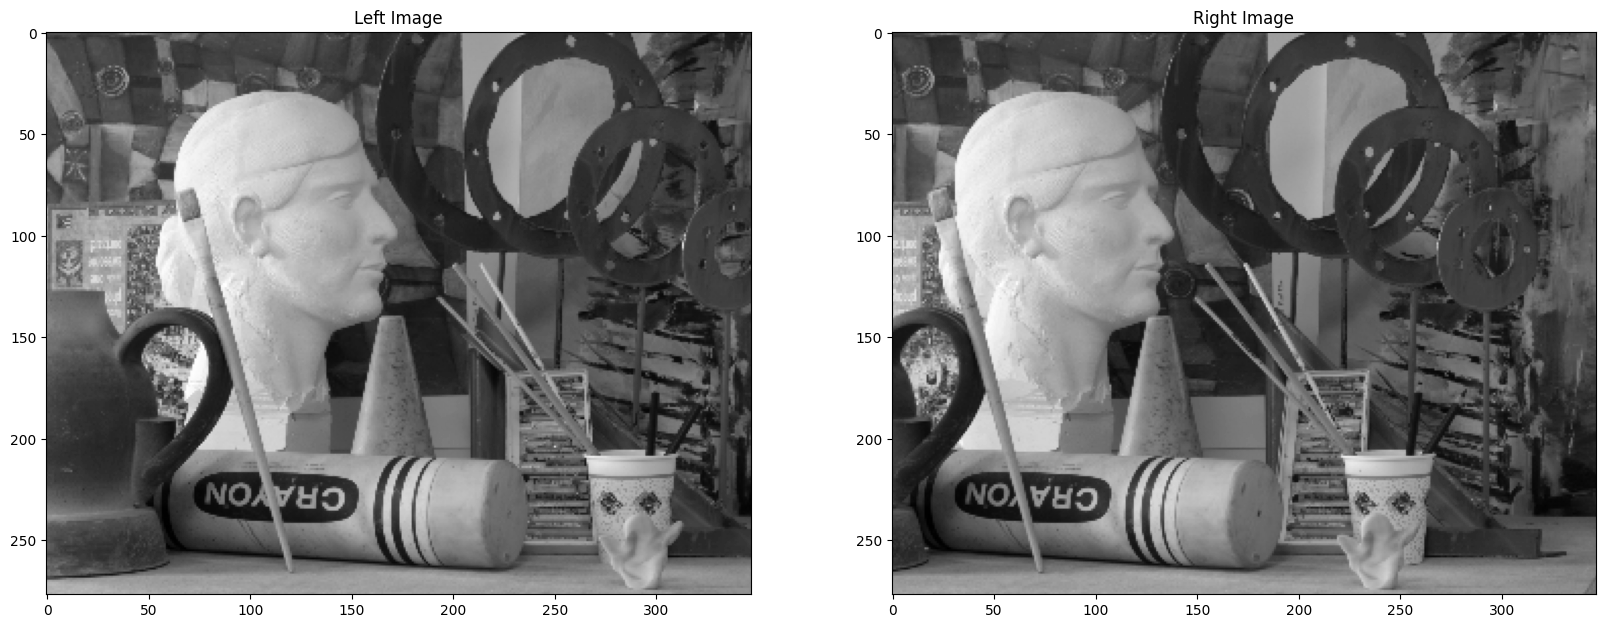

In [ ]:

def reflect_boundary(image_array, n):

    # Get the dimensions of the image
    height, width  = image_array.shape

    # Create an extended array with reflecting boundaries
    extended_array = np.pad(image_array, ((n, n), (n, n)), mode='reflect')

    return extended_array

def load_images(image_pair_name, downsample_factor):
    def _load_single_image(image_pair_name, format_number,downsample_factor):
        image_path = os.path.join('Middlebury', image_pair_name, 'view{}.png'.format(format_number))
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        if downsample_factor != 1:
            resize_height = image.shape[0] // downsample_factor
            resize_width = image.shape[1] // downsample_factor
            image = cv2.resize(image, (resize_width, resize_height))
        return image
    left = _load_single_image(image_pair_name, 1, downsample_factor)
    right = _load_single_image(image_pair_name, 5, downsample_factor)
    return left, right

def display_single_image(ax,image, title, epipolar_line_y):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    if epipolar_line_y:
        ax.axhline(y=epipolar_line_y, color='red', linestyle='--', linewidth=2)

def display_images(left, right, epipolar_line_y=None):
    joined_gray = np.concatenate([left, right], axis=1)
    fig, axs = plt.subplots(1,2)
    display_single_image(axs[0],left,'Left Image', epipolar_line_y)
    display_single_image(axs[1],right,'Right Image', epipolar_line_y)
    plt.show()


Il, Ir = load_images("Art", downsample_factor=downsample_factor)
display_images(Il, Ir)

## Define Helper Function: Produce Shifted Image

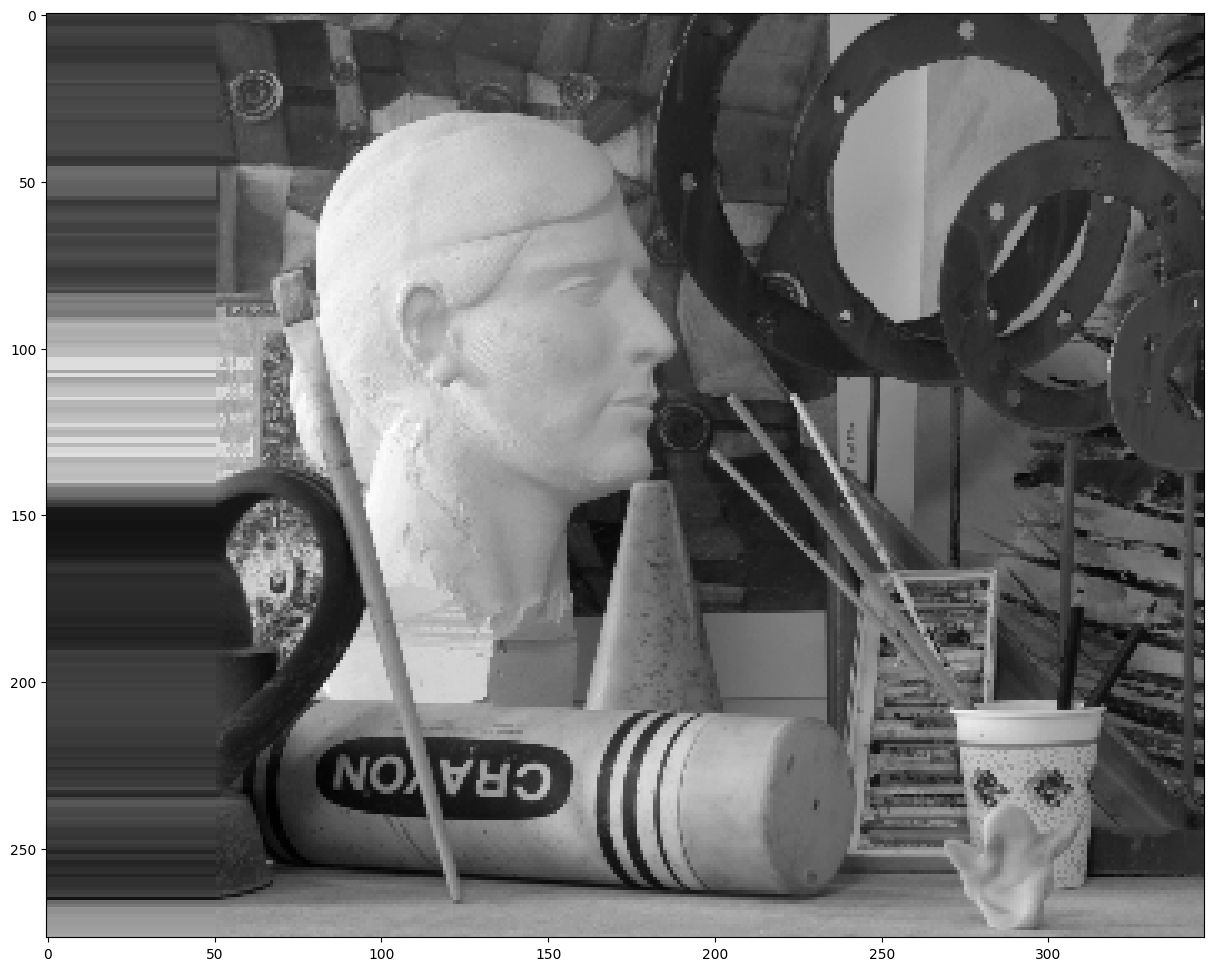

In [ ]:

def produce_shifted_image(image, shift_columns):
    '''
    Shift the image to the right. This function is useful for implementing Q1
    Inputs: image: Grayscale, (Height x Width),
             shift_columns: non negative integer for how far to shift the image to the right
    Output: the image, shifted to the right by shift columns. The rightmost column is copied to maintain the image size.
    '''

    if shift_columns == 0:
        return image
    first_column = image[:,0]
    shifts = np.tile(first_column, (shift_columns,1)).T
    cut_image=image[:,:-shift_columns]
    image = np.concatenate([shifts,cut_image],axis=1)
    return image

shift = 50
shifted_image = produce_shifted_image(Ir, shift)
plt.imshow(shifted_image, cmap='gray')
plt.show()

## Compute the Data Term (Copy from Task 1 Q1)

In [ ]:
def find_disp(Il,Ir, center_x,center_y, patch_size, dp):


    left =  center_y - patch_size // 2
    upper = center_x - patch_size // 2
    right = center_y + patch_size // 2
    lower =  center_x + patch_size // 2

    # Crop the image to extract the patch
    patch_l = Il[upper:lower+1 , left: right+1]
    img_r = produce_shifted_image(Ir , dp+1)
    patch_r = img_r[upper :lower+1 ,  left : right +1]

    #print(upper ,lower+1 ,  left-dp , right - dp +1)

    '''fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Plot the original image on the left
    axes[0].imshow(Il)
    axes[0].set_title('Original Image')

    # Plot the extracted patch on the right
    axes[1].imshow(patch_l)
    axes[1].set_title('Extracted Patch l ')
    axes[2].imshow(patch_r)
    axes[2].set_title('Extracted Patch r ')

    # Display the plots
    plt.show()'''

    return np.sqrt(1/(patch_size**2)*np.linalg.norm(patch_l-patch_r)**2)

def compute_data_term(Il, Ir, max_disparity, patch_size=5):
    '''
    Compute the data term: the RMSE between patches.
    Input:  left (base) and right (match) image: Grayscale, (Height x Width),
            max_disparity: non negative integer, the largest disparity value considered by the data term
            patch_size: non_negative, odd, integer. RMSE will be calculated in a window of
            dimensions (patch_size, patch_size) centered around the point of interest.
    Output: data_term: a (height x Width x max_disparity) numpy matrix, storing all of the rmse for
            all considered disparities at all pixels. More concretely, the value of data_term[y,x,d] will be
            the RMSE of matching point (y,x) of the base image to point (y, x-d) of the matching image
            In cases where the window for RMSE goes out of frame, you can assume reflecting boundary conditions.
    '''
    ######################################################################################################
    # TODO Q1: Implement the data term                                                                   #
    # See lecture 6 part B slide 4                                                                       #
    ######################################################################################################

    # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    img_h = Il.shape[0]
    img_w = Ir.shape[1]
    data_term = np.ones((img_h, img_w, max_disparity))
    n = patch_size//2
    Il_ref = reflect_boundary(Il, n)
    Ir_ref = reflect_boundary(Ir, n)

    for i in range(img_h):
      for j in range(img_w):
        for k in range(max_disparity):
          data_term[i,j,k] = find_disp(Il,Ir, i, j, patch_size, k)


    # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    return data_term

In [ ]:
from scipy import ndimage

sigma = 1.0
Il_s = ndimage.gaussian_filter(Il, sigma=1)
Ir_s = ndimage.gaussian_filter(Ir, sigma=1)

# Compute the data term for Il and Ir, and find disparities according to minimum data term
patch_size = 5
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
data_term  = compute_data_term(Il_s,Ir_s, max_disparity)

## Q1: Implement 2D Version in C++

> Indented block



**NOTE :- I have implemented this in python but the code is taking too long to run, but still I am submitting this as it is a high weight question , if we could score some step markings**

In [ ]:
P1= 1
P2= 5
patch_size = 5

def R(d1,d2):
  if(d1 == d2):
    return 0
  elif(abs(d1-d2) == 1):
    return P1
  else:
    return P2


def calc_miu_(x, y , d2):
  r = [(1,1), (0,1), (-1,1) , (1,0), (1,-1), (-1,-1), (0,-1),(-1,0)]
  sum_=0
  for index,direction in enumerate(r):
     min = 999999
     min_ind = 0
     for i in range(max_disparity):
          if(x == 0 or y == 0 or x == data_term.shape[0]-1 or y == data_term.shape[1]-1):
            try:
              miu_[index, x - direction[0] , y - direction[1] ,  i , d2] = data_term[x ,y , i] + R(i+1 , d2+1)
            except:
              pass
          else:
            try:
              miu_[index, x - direction[0] , y - direction[1] ,  i , d2] = np.min(miu_[index, x - 2*direction[0] , y - 2*direction[1] ,  i , :d2+1]) +data_term[x ,y , i] + R(i+1 , d2+1)
            except:
              pass
          try:
            if( miu_[index, x - direction[0] , y - direction[1] ,  i , d2] <  min):
                min_ind = i
                min = miu_[index, x - direction[0] , y - direction[1] ,  i , d2]
          except:
            pass
     if(min != 999999):
        sum_ += min
  return  sum_


disparities = np.zeros((data_term.shape[0], data_term.shape[1]))
miu_ = np.zeros((8 , data_term.shape[0] , data_term.shape[1] , max_disparity, max_disparity))

for i_ in range(data_term.shape[0]):
    for j_ in range(data_term.shape[1]):
      min = 999999
      min_ind = 0
      for k in range(max_disparity):
          fff = calc_miu_(i_, j_,  k)
          if( (fff + data_term[i_, j_, k]) < min):
            min = (fff + data_term[i_, j_, k] )
            min_ind = k
      disparities[i_ , j_] = (min_ind+1)



In [ ]:
plt.figure()
plt.imshow(disparities, cmap='gray')
plt.show()

In [ ]:
#
# The C-code is in sgm.ccp
# Use ./compile.sh to compile it
# PLEASE NOTE: The C-code is compiled into an .so file. In order to use it here you need to reload your kernel.
# For every test run, please do "Kernel -> Restart & Run All"
#

import sys
sys.path.append("build")

def sgm(data_term, P1=1, P2=5):
    from numpy.ctypeslib import ndpointer
    import ctypes
    import numpy as np

    # Load .so file
    lib = ctypes.cdll.LoadLibrary('./build/libsgm.so')

    # Set up C function call
    c_sgm = lib.sgm
    c_sgm.restype = None
    c_sgm.argtypes = [ndpointer(ctypes.c_double, flags='C_CONTIGUOUS'),
                      ndpointer(ctypes.c_double, flags='C_CONTIGUOUS'),
                      ndpointer(ctypes.c_uint8, flags='C_CONTIGUOUS'),
                      ctypes.c_int,
                      ctypes.c_int,
                      ctypes.c_int,
                      ctypes.c_float,
                      ctypes.c_float
                    ]

    # Convert data term to contigous array
    cont_data_term = np.ascontiguousarray(data_term, np.float64)

    # Allocate output arrays
    height, width = Il.shape[0], Il.shape[1]
    disparities = np.ascontiguousarray(np.zeros((height, width), dtype=np.uint8))
    messages = np.ascontiguousarray(np.zeros((8, height, width, max_disparity), dtype=np.float64))

    # Call the C function
    c_sgm(cont_data_term, messages, disparities, width, height, max_disparity, P1, P2)

    # Return values
    # Messages are returend only for debugging purposes
    return disparities, messages

# Compute data term
patch_size = 5
data_term = compute_data_term(Il, Ir, max_disparity, patch_size)

# Call SGM C-code
disparities, messages = sgm(data_term, 2, i)

# Visualize result
plt.figure()
plt.imshow(disparities, cmap='gray')
plt.show()